In [1]:
!git clone https://github.com/olivesgatech/Semi-supervised-Learning-for-Acoustic-Impedance-Inversion

Cloning into 'Semi-supervised-Learning-for-Acoustic-Impedance-Inversion'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 118 (delta 26), reused 41 (delta 16), pack-reused 57
Receiving objects: 100% (118/118), 97.38 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
%cd Semi-supervised-Learning-for-Acoustic-Impedance-Inversion/

/content/Semi-supervised-Learning-for-Acoustic-Impedance-Inversion


Step by step tutorial

load data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [4]:
data_dic = np.load("data/data.npy",allow_pickle=True).item()

seismic_data = data_dic["seismic"]
acoustic_impedance_data = data_dic["acoustic_impedance"]

num_samples = seismic_data.shape[0]

pre-process

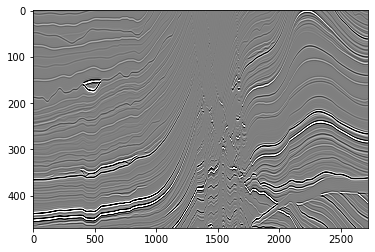

In [5]:
plt.figure()
std = np.std(seismic_data)
plt.imshow(seismic_data[:,0].T, aspect = 'auto', vmin = -2*std, vmax = 2*std, cmap = 'gray')

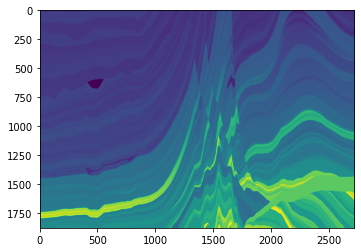

In [6]:
plt.figure()
plt.imshow(acoustic_impedance_data[:,0].T)

In [7]:
from sklearn.preprocessing import StandardScaler

seismic_normalization = StandardScaler().fit(seismic_data.reshape(-1, 1))
seismic_data = seismic_normalization.transform(seismic_data.reshape(-1, 1)).reshape(num_samples, 1, -1)

acoustic_normalization = StandardScaler().fit(acoustic_impedance_data.reshape(-1, 1))
acoustic_impedance_data = acoustic_normalization.transform(acoustic_impedance_data.reshape(-1, 1)).reshape(num_samples, 1, -1)

seismic_data = torch.Tensor(seismic_data)
acoustic_impedance_data = torch.Tensor(acoustic_impedance_data)

In [8]:
from torch.nn.functional import interpolate

seismic_data = interpolate(seismic_data, scale_factor = 4)

Set up data loader

In [9]:
from torch.utils import data

num_train_wells = 20
batch_size = 128
num_samples = seismic_data.shape[0]
indecies = np.arange(0,num_samples)
train_indecies = indecies[(np.linspace(0,len(indecies)-1, num_train_wells)).astype(int)]
test_indices = np.array([i for i in range(num_samples) if i not in train_indecies])

whole_data = data.TensorDataset(seismic_data,acoustic_impedance_data)

train_data = data.Subset(whole_data, train_indecies)
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = data.Subset(whole_data, test_indices)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=False)

whole_data_loader = data.DataLoader(whole_data, batch_size=batch_size, shuffle=False, drop_last=False)

unlabeled_loader = data.DataLoader(data.TensorDataset(seismic_data), batch_size=batch_size, shuffle=True)

get model

In [10]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.nn.functional import conv1d



class inverse_model(nn.Module):
    def __init__(self,resolution_ratio=4,nonlinearity="tanh"):
        super(inverse_model, self).__init__()
        self.resolution_ratio = resolution_ratio
        self.activation =  nn.ReLU() if nonlinearity=="relu" else nn.Tanh()

        self.cnn1 = nn.Sequential(nn.Conv1d(in_channels=1,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=2,
                                           dilation=1),
                                  nn.GroupNorm(num_groups=1,
                                               num_channels=8))

        self.cnn2 = nn.Sequential(nn.Conv1d(in_channels=1,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=6,
                                           dilation=3),
                                  nn.GroupNorm(num_groups=1,
                                               num_channels=8))

        self.cnn3 = nn.Sequential(nn.Conv1d(in_channels=1,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=12,
                                           dilation=6),
                                  nn.GroupNorm(num_groups=1,
                                               num_channels=8))

        self.cnn = nn.Sequential(self.activation,
                                 nn.Conv1d(in_channels=24,
                                           out_channels=16,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=1,
                                              num_channels=16),
                                 self.activation,

                                 nn.Conv1d(in_channels=16,
                                           out_channels=16,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=1,
                                              num_channels=16),
                                 self.activation,

                                 nn.Conv1d(in_channels=16,
                                           out_channels=16,
                                           kernel_size=1),
                                 nn.GroupNorm(num_groups=1,
                                              num_channels=16),
                                 self.activation)

        self.gru = nn.GRU(input_size=1,
                          hidden_size=8,
                          num_layers=3,
                          batch_first=True,
                          bidirectional=True)

        self.up = nn.Sequential(nn.ConvTranspose1d(in_channels=16,
                                                   out_channels=8,
                                                   stride=2,
                                                   kernel_size=4,
                                                   padding=1),
                                nn.GroupNorm(num_groups=1,
                                             num_channels=8),
                                self.activation,

                                nn.ConvTranspose1d(in_channels=8,
                                                   out_channels=8,
                                                   stride=2,
                                                   kernel_size=4,
                                                   padding=1),
                                nn.GroupNorm(num_groups=1,
                                             num_channels=8),
                                self.activation)

        self.gru_out = nn.GRU(input_size=16,
                              hidden_size=8,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)
        self.out = nn.Linear(in_features=16, out_features=1)


        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                nn.init.xavier_uniform_(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, nn.GroupNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        cnn_out1 = self.cnn1(x)
        cnn_out2 = self.cnn2(x)
        cnn_out3 = self.cnn3(x)
        cnn_out = self.cnn(torch.cat((cnn_out1,cnn_out2,cnn_out3),dim=1))

        tmp_x = x.transpose(-1, -2)
        rnn_out, _ = self.gru(tmp_x)
        rnn_out = rnn_out.transpose(-1, -2)

        x = rnn_out + cnn_out
#         x = self.up(x)

        tmp_x = x.transpose(-1, -2)
        x, _ = self.gru_out(tmp_x)

        x = self.out(x)
        x = x.transpose(-1,-2)
        return x



class forward_model(nn.Module):
    def __init__(self, wavelet_size = 121):
        super(forward_model, self).__init__()
        self.imp_to_reflectivity = nn.Conv1d(in_channels=1, 
                                             out_channels=1, 
                                             kernel_size=3,
                                             padding=1, 
                                             bias = False)
        self.imp_to_reflectivity.weight.requires_grad = False
        self.imp_to_reflectivity.weight.data = torch.Tensor([-1, 1, 0]).view(1, 1, -1)
        self.wavelet_size = wavelet_size
        
        self.half_wavelet = nn.Parameter(torch.randn(1, 1, self.wavelet_size)/self.wavelet_size, requires_grad = True)
#         self.wavelet = nn.Conv1d(in_channels=1,
#                              out_channels=1,
#                              kernel_size=self.wavelet_size,
#                              padding=int(wavelet_size/2))
    
    @property
    def device(self):
        return torch.device("cuda:0" if next(self.parameters()).is_cuda else "cpu")
    @property
    def wavelet(self):
        x = torch.zeros(1, 1, self.wavelet_size).to(self.device)
        x[0,0,self.wavelet_size//2] = 1
        x = nn.functional.conv1d(x, self.half_wavelet, padding = self.wavelet_size//2)
        x = nn.functional.conv_transpose1d(x, self.half_wavelet, padding = self.wavelet_size//2)
        return x
    def forward(self, x):
        x = self.imp_to_reflectivity(x)
        x = nn.functional.conv1d(x, self.half_wavelet, padding = self.wavelet_size//2)
        x = nn.functional.conv_transpose1d(x, self.half_wavelet, padding = self.wavelet_size//2)
#         x = self.wavelet(x)
        return x

In [11]:
from torch import nn, optim

inverse_net = inverse_model()
forward_net = forward_model()
optimizer = optim.Adam(list(inverse_net.parameters())+list(forward_net.parameters()), amsgrad=True,lr=0.005)

In [12]:
wavelet_init = forward_net.wavelet.clone()

In [13]:
imp_est = inverse_net(next(iter(unlabeled_loader))[0])
imp_est.shape

torch.Size([128, 1, 1880])

In [14]:
forward_net(imp_est).shape

torch.Size([128, 1, 1880])

In [15]:
inverse_net.train()
criterion = nn.MSELoss()

In [16]:
#%% Metrics
def metrics(y,x):
    #x: reference signal
    #y: estimated signal

    x = x.numpy()

    y = y.numpy()

    #corrlation
    x_mean = np.mean(x, axis=-1, keepdims=True)
    y_mean = np.mean(y, axis=-1, keepdims=True)
    x_std = np.std(x, axis=-1, keepdims=True)
    y_std = np.std(y, axis=-1, keepdims=True)
    corr = np.mean((x-x_mean)*(y-y_mean), axis=-1,keepdims=True)/(x_std*y_std)

    #coefficeint of determination (r2)
    S_tot = np.sum((x-x_mean)**2, axis=-1, keepdims=True)
    S_res = np.sum((x - y)**2, axis=-1, keepdims=True)

    r2 = (1-S_res/S_tot)

    return torch.tensor(corr), torch.tensor(r2)


Training the model


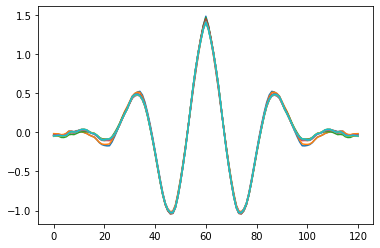

In [19]:
from tqdm.auto import tqdm

max_epoch = 100
alpha = 1
beta = 0.2
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
inverse_net.to(device)
forward_net.to(device)


print("Training the model")
best_loss = np.inf
for epoch in tqdm(range(max_epoch)):
    train_loss = []
    train_property_corr = []
    train_property_r2 = []
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = inverse_net(x)
        x_rec = forward_net(y)

        property_loss = criterion(y_pred,y)+criterion(x_rec, x)
        corr, r2 = metrics(y_pred.detach().cpu(),y.detach().cpu())
        train_property_corr.append(corr)
        train_property_r2.append(r2)

        if beta!=0:
            #loading unlabeled data
            try:
                x_u = next(unlabeled)[0]
            except:
                unlabeled = iter(unlabeled_loader)
                x_u = next(unlabeled)[0]
            x_u = x_u.to(device)
            y_u_pred = inverse_net(x_u)
            x_u_rec = forward_net(y_u_pred)

            seismic_loss = criterion(x_u_rec,x_u)
        else:
            seismic_loss=0
        loss = alpha*property_loss + beta*seismic_loss
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().clone())
        if epoch % 10 == 0:
            wavelet = forward_net.wavelet.clone().detach().cpu()
            plt.plot(wavelet.squeeze())


In [20]:
def display_results(loss, property_corr, property_r2, header):
    property_corr = torch.mean(torch.cat(property_corr), dim=0).squeeze()
    property_r2 = torch.mean(torch.cat(property_r2), dim=0).squeeze()
    loss = torch.mean(torch.tensor(loss))
    print("loss: {:.4f}\nCorrelation: {:0.4f}\nr2 Coeff.  : {:0.4f}".format(loss,property_corr,property_r2))



predicted_impedance = []
true_impedance = []
test_property_corr = []
test_property_r2 = []
inverse_net.eval()
print("\nTesting the model\n")

with torch.no_grad():
    test_loss = []
    for x, y in tqdm(whole_data_loader, total = len(whole_data_loader)):
        x = x.to(device)
        y_pred = inverse_net(x)
        property_loss = criterion(y_pred.cpu(),y)/np.prod(y.shape)
        corr, r2 = metrics(y_pred.detach().cpu(),y.detach().cpu())
        test_property_corr.append(corr)
        test_property_r2.append(r2)

        x_rec = forward_net(y_pred)
        seismic_loss = criterion(x_rec.cpu(), x.cpu())/np.prod(x.shape)
        loss = alpha*property_loss + beta*seismic_loss
        test_loss.append(loss.cpu().item())

        true_impedance.append(y)
        predicted_impedance.append(y_pred)


    display_results(test_loss, test_property_corr, test_property_r2, header="Test")

    predicted_impedance = torch.cat(predicted_impedance, dim=0)
    true_impedance = torch.cat(true_impedance, dim=0)
    
    n_ = predicted_impedance.shape[0]
    predicted_impedance = acoustic_normalization.inverse_transform(predicted_impedance.cpu().numpy().reshape(-1, 1)).reshape(n_, 1, -1)
    true_impedance = acoustic_normalization.inverse_transform(true_impedance.cpu().numpy().reshape(-1, 1)).reshape(n_, 1, -1)


Testing the model




loss: 0.0000
Correlation: 0.9357
r2 Coeff.  : 0.8014


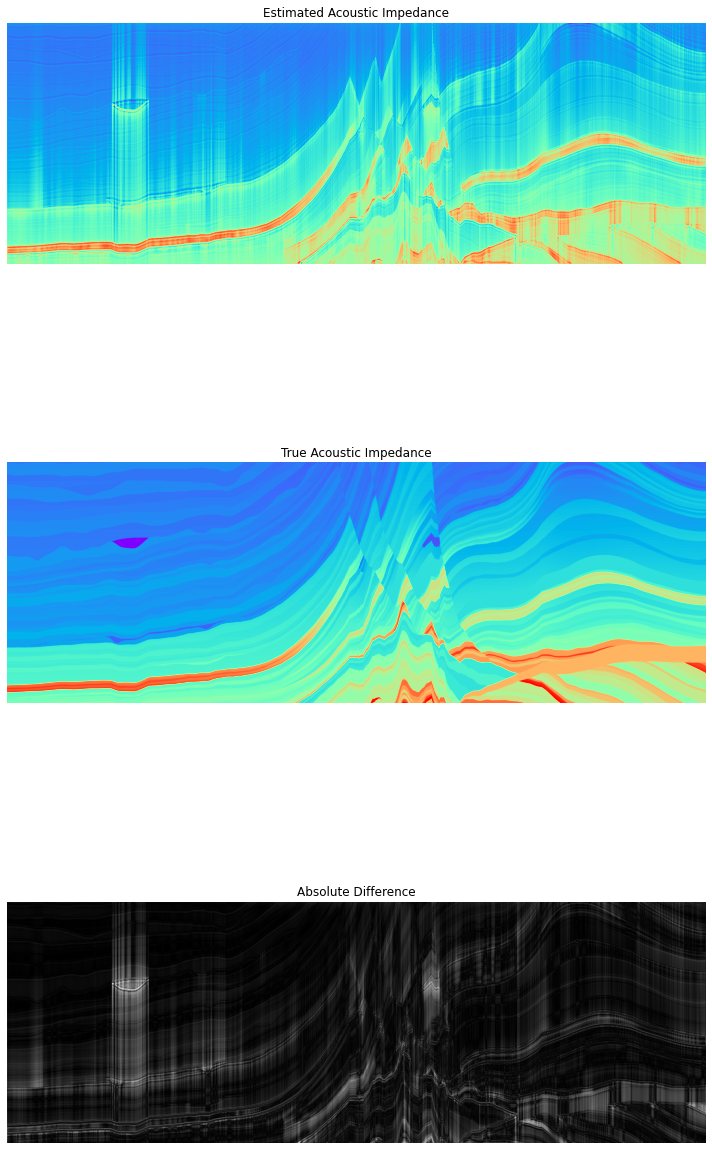

In [21]:
#diplaying estimated section

plt.figure(figsize = (10, 20))
plt.subplot(3,1,1)
plt.imshow(predicted_impedance[:,0].T, cmap='rainbow',aspect=0.5, vmin=true_impedance.min(), vmax=true_impedance.max())
plt.axis('off')
plt.title("Estimated Acoustic Impedance")

plt.subplot(3,1,2)
plt.imshow(true_impedance[:,0].T, cmap='rainbow',aspect=0.5,vmin=true_impedance.min(), vmax=true_impedance.max())
plt.title("True Acoustic Impedance")
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(abs(true_impedance[:,0].T-predicted_impedance[:,0].T), cmap='gray',aspect=0.5)
plt.title("Absolute Difference")
plt.axis('off')

plt.tight_layout()


plt.show()

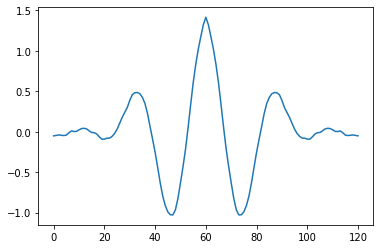

In [24]:
plt.figure()
wavelet_final = forward_net.wavelet.detach().cpu()
plt.plot(wavelet_final.squeeze())
# plt.plot(wavelet_init.squeeze().detach().numpy())
plt.show()

#Application
## Setup

In [23]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

In [26]:
!pip install segpy

import segpy
from segpy.reader import create_reader

     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 112kB 14.1MB/s 


In [27]:
filename = "Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

## Match histograms

In [115]:
seismic_data_2 = data[100,:,:]

num_samples = seismic_data_2.shape[0]


In [116]:
from skimage.exposure import match_histograms

reference = seismic_data[:,0,:].numpy()
image = seismic_data_2

seismic_data_2 = match_histograms(image, reference, multichannel=False)

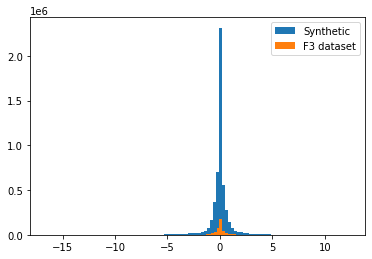

In [117]:
plt.figure()
plt.hist(reference.flatten(), bins=100)
plt.hist(seismic_data_2.flatten(), bins=100)
plt.legend(['Synthetic', 'F3 dataset'])
plt.show()

In [118]:
from sklearn.preprocessing import StandardScaler

seismic_normalization_2 = StandardScaler().fit(seismic_data_2)
seismic_data_2 = seismic_normalization_2.transform(seismic_data_2)

seismic_data_2 = torch.Tensor(seismic_data_2)

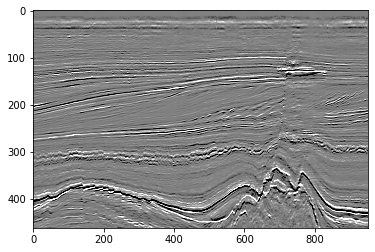

In [119]:
std = np.std(seismic_data_2.numpy())

plt.figure()
plt.imshow(seismic_data_2.numpy(), aspect = 'auto', vmin = -2*std, vmax = 2*std, cmap = 'gray')
plt.show()

In [120]:
ai = inverse_net(seismic_data_2.unsqueeze(1).to('cuda')).cpu().detach().numpy()

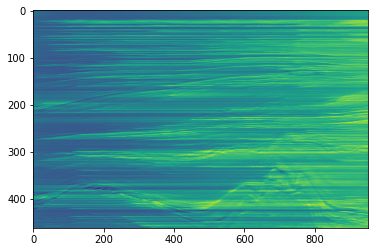

In [121]:
plt.imshow(ai[:,0,:], aspect = 'auto')
plt.show()